In [1]:
%load_ext autoreload
%env SPARK_HOME=/usr/hdp/current/spark2-client

import findspark
findspark.init()

print('findspark initialized ...')

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import expr, col, column, max, min

spark = SparkSession.builder.appName('mlonspark')\
    .config('spark.executor.instances', '7')\
    .getOrCreate()

print('pyspark ready ...')

env: SPARK_HOME=/usr/hdp/current/spark2-client
findspark initialized ...
pyspark ready ...


In [2]:
from pyspark.ml.recommendation import ALS
def initalg(val):
    return ALS()\
    .setUserCol("userId")\
    .setItemCol("artistId")\
    .setRatingCol("scaled-by-artist")\
    .setRank(val)\
    .setImplicitPrefs(True)


In [3]:
train = spark.read.load("/data/lastfm-dataset-360K/coo-data-train.parquet")
test = spark.read.load("/data/lastfm-dataset-360K/coo-data-test.parquet")

In [4]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import isnan

evaluator = RegressionEvaluator()\
    .setMetricName("rmse")\
    .setLabelCol("scaled-by-artist")\
    .setPredictionCol("prediction")

def runtest(rng, **model_kargs):
    res = []
    for i in rng:
        alg = initalg(i)
        model = alg.fit(train)
        trainPredictions = model.transform(train)
        trainPredictionsFiltered = trainPredictions.where(~isnan(col("prediction")))  
        trainRmse = evaluator.evaluate(trainPredictionsFiltered)
        testPredictions = model.transform(test)
        testPredictionsFiltered = testPredictions.where(~isnan(col("prediction")))    
        testRmse = evaluator.evaluate(testPredictionsFiltered)
        res.append([i, trainRmse, testRmse])
    return res

In [5]:
import numpy as np
rng = np.arange(4, 20, 2).tolist()
res = runtest(rng)
print(res)

[[4, 1.8312562499259424, 1.8200674353786752], [6, 1.8243237528279501, 1.813985292584728], [8, 1.8192694650332906, 1.8097974787113753], [10, 1.8150913991222395, 1.806358402331048], [12, 1.8118973774496192, 1.8038473371202555], [14, 1.808762453836756, 1.8013194349991153], [16, 1.8058405896067982, 1.7991328875373385], [18, 1.803375072537978, 1.79726154480979]]


In [6]:
x = []
yTrain = []
yTest = []
for v in res:
    x.append(v[0])
    yTrain.append(v[1])
    yTest.append(v[2])

print(yTest)

[1.8200674353786752, 1.813985292584728, 1.8097974787113753, 1.806358402331048, 1.8038473371202555, 1.8013194349991153, 1.7991328875373385, 1.79726154480979]


Text(0, 0.5, 'RMSE')

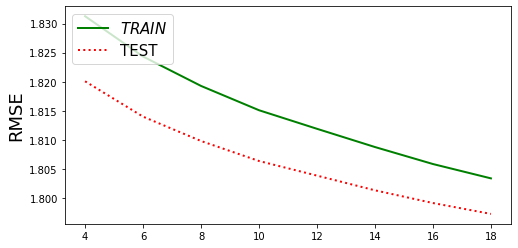

In [7]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(x, yTrain, "g-", linewidth=2, label=r"$TRAIN$")
plt.plot(x, yTest, "r:", linewidth=2, label=r"TEST")
plt.legend(loc="upper left", fontsize=15)
plt.ylabel("RMSE", fontsize=18)